# Building Makemore Part II: MLP
https://www.youtube.com/watch?v=TCH_1BHY58I

Imports

In [115]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Get Wordlist

In [116]:
words = open("names.txt", 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [117]:
len(words)

32033

Build the vocabulary of characters.

In [118]:
chars = sorted(list(set(''.join(words))))
print(chars)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Create an string to integer `(stoi)` dictionary from the characters.

In [119]:
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


Create a reverse integer to string `(itos)` dictionary.

In [120]:
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Build the Dataset
For this model, if we have the name 'emma', we want to use the three characterse before as context to predict the next one.
So `— — E` (which will be our xs) predicts `M` (our y label), and `— E M` predicts `A`, and so on.

But of course, in order to do this, we need to turn those letters into numbers: E ⇨ 5, M ⇨ 13, etc.

And the end goal is to build a neural network where the vector `[0, 0, 5]` predicts `[13]`, and `[0, 5, 13]` predicts `[13]`, and so on.

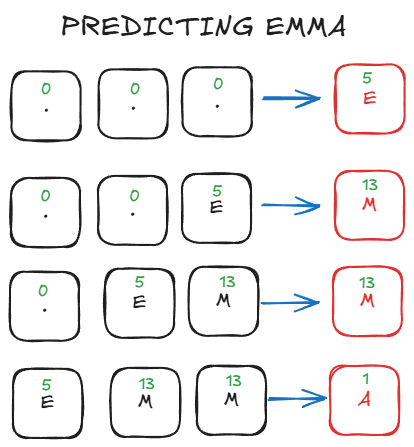


In [121]:
block_size = 3 # this is the context length
X, Y = [], [] # initializing the list

# go through all words in word list (in this case, 1 for proof of concept)
for w in words[:1]:
    context = [0] * block_size
    
    # go through all characters of each word, plust the terminator (.) character
    print('——————————')
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '⇨', itos[ix])
        context = context[1:] + [ix]



——————————
... ⇨ e
..e ⇨ m
.em ⇨ m
emm ⇨ a
mma ⇨ .


Convert X and Y into tensors which we will use in neural net.

In [122]:
X = torch.tensor(X)
Y = torch.tensor(Y)
X[:5], Y[5:]

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1]]),
 tensor([], dtype=torch.int64))

X = torc


In [123]:
X.shape, X.dtype

(torch.Size([5, 3]), torch.int64)

In [124]:
Y.shape, Y.dtype

(torch.Size([5]), torch.int64)

https://youtu.be/TCH_1BHY58I?si=fWk0RD0pTRkTGKqW&t=735

## Create lookup table.

The lookup table `C` is a simple matrix where each row represents one character's embedding vector.

- **Shape**: 27 rows (one for each character) × 2 columns (embedding dimension)  
- **Purpose**: Convert character indices like `[5, 13, 13]` into embedding vectors
- **Operation**: `C[5]` literally looks up row 5 and returns that character's 2D vector
- **Example**: Character 5 (E) → `C[5]` → `tensor([-0.2733, 0.2133])` 
- **Result**: `[5, 13, 13]` becomes three 2D vectors representing E, M, M

**How the transformation works:**
- Input: `[5, 13, 13]` (three character indices)
- Index 5 → Row 5 of C → `[-0.2733, 0.2133]` (embedding for 'E')
- Index 13 → Row 13 of C → `[1.0467, 1.6703]` (embedding for 'M') 
- Index 13 → Row 13 of C → `[1.0467, 1.6703]` (same embedding for 'M' again)
- Output: 3 sets of 2 numbers each = `[[-0.2733, 0.2133], [1.0467, 1.6703], [1.0467, 1.6703]]`

It's called a "lookup table" because you're literally looking up values in a table using character indices!

In [125]:
C = torch.randn((27, 2))

In [126]:
# Display lookup table with corresponding letters
print("LOOKUP TABLE C - Character Embeddings (27×2)")
print("=" * 50)
print(f"{'Index':<5} {'Char':<4} {'Embedding Vector'}")
print("-" * 50)
for i in range(27):
    char = itos[i]
    vector = C[i]
    print(f"{i:<5} '{char}'   {vector}")

LOOKUP TABLE C - Character Embeddings (27×2)
Index Char Embedding Vector
--------------------------------------------------
0     '.'   tensor([-0.2307,  1.3694])
1     'a'   tensor([-1.6721, -0.7404])
2     'b'   tensor([-0.0954, -1.9635])
3     'c'   tensor([-0.2832,  0.6872])
4     'd'   tensor([-0.3898, -0.8016])
5     'e'   tensor([-0.7597, -1.6744])
6     'f'   tensor([ 0.4816, -0.0130])
7     'g'   tensor([0.5459, 0.9340])
8     'h'   tensor([2.3576, 0.7925])
9     'i'   tensor([ 0.2951, -0.4776])
10    'j'   tensor([-0.0701, -0.3652])
11    'k'   tensor([-2.6453, -0.0053])
12    'l'   tensor([-0.9476, -1.0495])
13    'm'   tensor([-1.4150,  0.8569])
14    'n'   tensor([-0.9076, -0.6030])
15    'o'   tensor([-0.5314,  0.6298])
16    'p'   tensor([-1.4896, -1.8435])
17    'q'   tensor([0.8362, 0.1061])
18    'r'   tensor([0.3649, 0.9212])
19    's'   tensor([ 1.3821, -0.1344])
20    't'   tensor([0.5702, 0.1510])
21    'u'   tensor([-0.1359,  0.1924])
22    'v'   tensor([0.1288, 

## Create Embedding Vector

In [127]:
emb = C[X]

In [128]:
# Show how C[X] converts character indices to embedding vectors
print("C[X] - Converting all character indices to embeddings")
print("=" * 60)
print()

# Show first few examples
for i in range(min(5, len(X))):
    context = X[i]
    embeddings = C[X[i]]
    
    # Convert indices to characters for display
    chars_in_context = [itos[idx.item()] for idx in context]
    
    print(f"Example {i+1}:")
    print(f"  Input context: {context.tolist()} → {chars_in_context}")
    print(f"  Embeddings:")
    for j, (char, embed) in enumerate(zip(chars_in_context, embeddings)):
        print(f"    '{char}' (index {context[j].item()}) → {embed.tolist()}")
    print()

print(f"Full C[X] shape: {C[X].shape}")
print("This means:")
print(f"  - {C[X].shape[0]} training examples")
print(f"  - {C[X].shape[1]} characters per context") 
print(f"  - {C[X].shape[2]} embedding dimensions per character")

C[X] - Converting all character indices to embeddings

Example 1:
  Input context: [0, 0, 0] → ['.', '.', '.']
  Embeddings:
    '.' (index 0) → [-0.23073112964630127, 1.3693658113479614]
    '.' (index 0) → [-0.23073112964630127, 1.3693658113479614]
    '.' (index 0) → [-0.23073112964630127, 1.3693658113479614]

Example 2:
  Input context: [0, 0, 5] → ['.', '.', 'e']
  Embeddings:
    '.' (index 0) → [-0.23073112964630127, 1.3693658113479614]
    '.' (index 0) → [-0.23073112964630127, 1.3693658113479614]
    'e' (index 5) → [-0.7597295045852661, -1.6743587255477905]

Example 3:
  Input context: [0, 5, 13] → ['.', 'e', 'm']
  Embeddings:
    '.' (index 0) → [-0.23073112964630127, 1.3693658113479614]
    'e' (index 5) → [-0.7597295045852661, -1.6743587255477905]
    'm' (index 13) → [-1.4149680137634277, 0.8569070100784302]

Example 4:
  Input context: [5, 13, 13] → ['e', 'm', 'm']
  Embeddings:
    'e' (index 5) → [-0.7597295045852661, -1.6743587255477905]
    'm' (index 13) → [-1.4149

Creating the embedding

In [129]:
emb = C[X]

In [130]:
emb[0]

tensor([[-0.2307,  1.3694],
        [-0.2307,  1.3694],
        [-0.2307,  1.3694]])